# The University of Melbourne, School of Computing and Information Systems
# COMP90049 Introduction to Machine Learning, 2020 Semester 1
-----
## Project 1: Understanding Student Success with Naive Bayes
-----
###### Student Name(s): Diego Aranda Villarreal (992038)
###### Python version: Python 3.8.2
###### Submission deadline: 11am, Wed 22 Apr 2019

This iPython notebook is a template which you will use for your Project 1 submission. 

Marking will be applied on the five functions that are defined in this notebook, and to your responses to the questions at the end of this notebook.

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find. 

-------------------------------------------------------------------------------------------------------------------------------

The following functions are defined in order to construct the Naive Bayes Model from scratch, including load_data(), split_data(), train(), predict(), evaluate(). Also, we include 2 more helper functions for responding particular questions. A thorough explanation for these functions is given in Q1.b.

In [221]:
# This function should open a data file in csv, and transform it into a usable format 
def load_data():
    data = pd.read_csv('student.csv', sep=',')
    return data

In [222]:
# This function should split a data set into a training set and hold-out test set
def split_data(dataCopy, splitFactor):
    trainData = dataCopy.sample(frac = splitFactor)
    testData = dataCopy.drop(trainData.index)
    # For each list, the indexes are reset for posterior navigation through lists
    Xtr = trainData.iloc[:, :-1]
    Xtr.reset_index(drop = True, inplace = True)
    Xte = testData.iloc[:, :-1]
    Xte.reset_index(drop = True, inplace = True)
    ytr = trainData.iloc[:, -1]
    ytr.reset_index(drop = True, inplace = True)
    yte = testData.iloc[:, -1]
    yte.reset_index(drop = True, inplace = True)
    return Xtr, Xte, ytr, yte

In [223]:
# This function should build a supervised NB model
def train(X_train, y_train, yClass, Xfeat):
    
    # Prepare data for traveling through lists
    trainData = X_train # Create a train list for navigating
    trainData['Grade'] = y_train # Add classes column to train list
    yClassCount = y_train.value_counts() # Class count for each class
    yClassCount = yClassCount.sort_index() # Sort list of class counts
    
    # Feature categories dictionary
    featCatDic = {} # Create an empty dictionary for feature categories
    for f in Xfeat: # Travel through all the features
        auxCat = list(trainData[f].value_counts().index) # Create the list of categories for each feature
        auxCat.sort() # Sort to order the categories
        featCatDic[f] = auxCat # Store a new feature with its categories in the Features dictionary
        
    # Likelihoods dictionary
    probDic = {} # Create an empty dictionary for likelihoods
    for f in Xfeat:
        auxProb = pd.DataFrame(0, index = featCatDic[f], columns = yClass) # Create a DataFrame for the likelihoods filled with zeros
        probDic[f] = auxProb # Store a new likelihood Dataframe for each feature
        
    # Count of categories seen in each instance for each feature
    # Travel through each feature f, create a dictionary to hold the counts per category k
    countDic = {} # Create a dictionary for counting feature categories
    for f in Xfeat: # Go through each feature
        auxDic = {}
        for k in range(len(featCatDic[f])): # Go through each feature category
            aux = trainData[trainData[f] == featCatDic[f][k]] # Store the instances for a particular feature category
            aux = aux.iloc[:, -1] # Store the classes for all those instances
            aux = aux.sort_values() # Sort the classes values
            aux = aux.value_counts() # Count the category values per class
            if len(aux) < len(yClass): # Compare list of categories per feature against class count list
                yClassAux = list(aux.index) # Store indexes of list of sum of classes 
                yClassAdd = list(yClass) # Copy class count list
                for y in yClassAux: # Travel through each index of classes per category per feature
                    yClassAdd.remove(y)# Once we count, we remove the index
                for y in yClassAdd:# Travel through each class not found for the respective category
                    aux[y] = 0 # If we don't find any value, we fill with zero
            auxDic[featCatDic[f][k]] = aux # Store the counts for a particular category of a feature
        countDic[f] = auxDic # Store the counts of all categories that belong to a particular feature
        
    # Calculate likelihood as dictionary, using Laplace Smoothing
    # f for features - c for feature categories - k for classes
    # Travel through the probDic for each feature f, each feature category c (from featCatDic) for each class k
    # Then divide count of feature values by class count using Laplace Smoothing, for zero values
    for f in Xfeat:
        for c in featCatDic[f]: # 
            for k in range(len(yClassCount)):
                probDic[f].loc[c, yClassCount.index[k]] = (1 + countDic[f][c][yClassCount.index[k]]) / (len(featCatDic[f]) + yClassCount[k])
    
    # Calculate prior probabilities
    # Travel through each class i, then count found values in the whole train list, then divide by the total count of class list
    y_prior = {}
    for i in range(len(yClass)):
        count = 0
        for j in range(len(y_train)):
            currentGrade = yClass[i]
            if yClass[i] == y_train[j]:
                count = count + 1
        y_prior[currentGrade] = count/len(y_train)
    
    return probDic, y_prior

In [224]:
# This function should predict the class for an instance or a set of instances, based on a trained model 
def predict(y_prior, X_test, probDic, yClass, Xfeat):
    y_pred = []
    for i in range(len(X_test)): # Travel through test instances
        y_hat = {} # Create a list for y hat values
        for k in range(len(yClass)): # Travel through each class for creating y hat list
            y_hat[yClass[k]] = 0 # Create y hat list full of zeros  
        for l in yClass: # Travel through each class for calculating y hat values
            for f in Xfeat: # Travel through each feature
                y_hat[l] = y_hat[l] + math.log(probDic[f].loc[X_test.loc[i,f], l]) # Calculate sum of likelihoods
            y_hat[l] = math.log(y_prior[l]) + y_hat[l] # Calculate y hat value for each class
        y_hatValues = list(y_hat.values()) # Create a list of y hat values 
        y_hatKeys = list(y_hat.keys()) # Create a list of keys for y hat values
        prediction = y_hatKeys[y_hatValues.index(max(y_hatValues))] # take the "argmax" of the list
        y_pred.append(prediction) # add a new prediction
    return y_pred

In [225]:
# This function should evaluate a set of predictions in terms of accuracy
def evaluate(y_test, y_pred, question):
    if question == 1 or question == 3:
        return metrics.accuracy_score(y_test, y_pred)
    elif question == 2:
        return metrics.classification_report(y_test, y_pred, digits=6)

In [226]:
def runModelA(dataCopy, splitFactor, question):
    # Split data
    X_train, X_test, y_train, y_test = split_data(dataCopy, splitFactor)

    # Lists for traveling through dictionaries
    Xfeat = list(X_train.columns) # Features list
    yClass = list(y_train.value_counts().index) # Class count list
    yClass.sort()

    # Train
    probDic, y_prior = train(X_train, y_train, yClass, Xfeat)

    # Predict
    y_pred = predict(y_prior, X_test, probDic, yClass, Xfeat)

    # Evaluation
    return evaluate(y_test, y_pred, question)

In [227]:
def runModelC(X_train, y_train, X_test, y_test, question):
    # Lists for traveling through dictionaries
    Xfeat = list(X_train.columns) # Features list
    yClass = list(y_train.value_counts().index) # Class count list
    yClass.sort()

    # Train
    probDic, y_prior = train(X_train, y_train, yClass, Xfeat)

    # Predict
    y_pred = predict(y_prior, X_test, probDic, yClass, Xfeat)

    # Evaluation
    return evaluate(y_test, y_pred, question)

## Questions (you may respond in a cell or cells below):

You should respond to Question 1 and two additional questions of your choice. A response to a question should take about 100–250 words, and make reference to the data wherever possible.

### Question 1: Naive Bayes Concepts and Implementation

- a Explain the ‘naive’ assumption underlying Naive Bayes. (1) Why is it necessary? (2) Why can it be problematic? Link your discussion to the features of the students data set. [no programming required]
- b Implement the required functions to load the student dataset, and estimate a Naive Bayes model. Evaluate the resulting classifier using the hold-out strategy, and measure its performance using accuracy.
- c What accuracy does your classifier achieve? Manually inspect a few instances for which your classifier made correct predictions, and some for which it predicted incorrectly, and discuss any patterns you can find.

### Question 2: A Closer Look at Evaluation

- a You learnt in the lectures that precision, recall and f-1 measure can provide a more holistic and realistic picture of the classifier performance. (i) Explain the intuition behind accuracy, precision, recall, and F1-measure, (ii) contrast their utility, and (iii) discuss the difference between micro and macro averaging in the context of the data set. [no programming required]
- b Compute precision, recall and f-1 measure of your model’s predictions on the test data set (1) separately for each class, and (2) as a single number using macro-averaging. Compare the results against your accuracy scores from Question 1. In the context of the student dataset, and your response to question 2a analyze the additional knowledge you gained about your classifier performance.

### Question 3: Training Strategies 

There are other evaluation strategies, which tend to be preferred over the hold-out strategy you implemented in Question 1.
- a Select one such strategy, (i) describe how it works, and (ii) explain why it is preferable over hold-out evaluation. [no programming required]
- b Implement your chosen strategy from Question 3a, and report the accuracy score(s) of your classifier under this strategy. Compare your outcomes against your accuracy score in Question 1, and explain your observations in the context of your response to question 3a.

### Question 4: Model Comparison

In order to understand whether a machine learning model is performing satisfactorily we typically compare its performance against alternative models. 
- a Choose one (simple) comparison model, explain (i) the workings of your chosen model, and (ii) why you chose this particular model. 
- b Implement your model of choice. How does the performance of the Naive Bayes classifier compare against your additional model? Explain your observations.

### Question 5: Bias and Fairness in Student Success Prediction

As machine learning practitioners, we should be aware of possible ethical considerations around the
applications we develop. The classifier you developed in this assignment could for example be used
to classify college applicants into admitted vs not-admitted – depending on their predicted
grade.
- a Discuss ethical problems which might arise in this application and lead to unfair treatment of the applicants. Link your discussion to the set of features provided in the students data set. [no programming required]
- b Select ethically problematic features from the data set and remove them from the data set. Use your own judgment (there is no right or wrong), and document your decisions. Train your Naive Bayes classifier on the resulting data set containing only ‘unproblematic’ features. How does the performance change in comparison to the full classifier?
- c The approach to fairness we have adopted is called “fairness through unawareness” – we simply deleted any questionable features from our data. Removing all problematic features does not guarantee a fair classifier. Can you think of reasons why removing problematic features is not enough? [no programming required]


-------------------------------------------------------------------------------------------------------------------------------

Assumptions:

- We assume that the person who will put the mark will have the student.csv file in the same folder of our jupyter notebook project file in order to check that the code runs.
- The results for Q1.c, Q2.b and Q3.b were discussed based on a particular run from Q1, and each cell has proof of that particular run. For all that, we provided enough information with images in our response cells, so the person who will mark us can run the code again, but keep in mind that running the code again will lead to different results.

Word counts for questions (1755 words in total):

- Q1.a = 258
- Q1.b = 237
- Q1.c = 256
- Q2.a = 255
- Q2.b = 257
- Q3.a = 254
- Q3.b = 238

Question 1

a.	Naïve Bayes classifier is a supervised machine learning classification model based on the Bayes rule. Bayes Rule allows us to calculate the posterior probability P(Y/X) w.r.t. the likelihood P(X/Y), the prior probability of the classes P(Y) and the prior probability of the predictors P(X) as P(Y/X) = (P(X/Y)*P(Y))/P(X), with X as features and Y as classes. Our objective is to calculate the most likely class Y^ given a test instance X_test by retrieving the maximum value for all the classes (argmax). 

If we solve this problem directly for the (argmax) function, it will be infeasible because of the amount of parameters to be calculated. The Naïve assumption allows us to assume that given a class label Y, all the values of individual features are independent of one another (conditional independence assumption), thus, making the model feasible computationally, simple to implement and easy to interpret.

However, that might be problematic for our particular dataset. For example, we could think of feature pairs such as health/nursery, absences/failures, Pstatus/famrel or internet/failures would be highly dependent between each other, and by making this assumption we might be losing some information in terms of the parameters. So, there is a trade-off between the feasibility/simplicity/interpretability versus having the whole information for the parameters. Also, the assumption might cause problems when calculating likelihoods which have not been observed in the training dataset. In that case, NB model will assign a 0 probability, thus, unable to calculate a prediction in specific test instances (although, for this particular assignment, we use Laplace Smoothing to avoid this).

b.	The Naïve Bayes classifier was constructed including the load_data(), split_data(), train(), predict() and evaluate() functions which included basic python libraries and other libraries from the whitelist, such as numpy and sklearn. In addition, we included some helper functions for responding to the different questions of the assignment. We selected the test size by using random subsampling technique with our Naïve Bayes model with 50 iterations, in which we selected the moderate mean value among three test sizes (0.75, 0.8 and 0.9) for the variance of our estimators to be moderate, so, we selected a test size of 20% for  our responses (130 instances for testing, 519 instances for training). We included a helper function for selecting the running random subsampling, runModelA() function, so we can iterate across our model. The load_data() function uses pandas for reading the csv file. The split_data() function has been constructed manually for datatype management purposes. The train() function was constructed by using dictionaries, one dictionary for holding the likelihoods of the model (with Laplace smoothing) and other dictionary for holding the prior probabilities (the details of each dictionary can be seen in the comments of the code). The predict() function was constructed by taking both dictionaries from above function and applying log-transformation to avoid underflowing the results. Finally, the evaluation was constructed by using the sklearn metrics library for assessing accuracy and using the hold-out strategy as instructed by the lecturer.

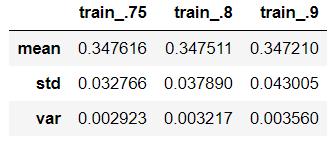

c.	The example run shows an accuracy value of 0.423. We make a simple inspection of how our model works by using groupby() function over our y_test and y_pred columns to see the predicted values for each of our classes clearly. We can see that the model might be working better for classes C/D/F.

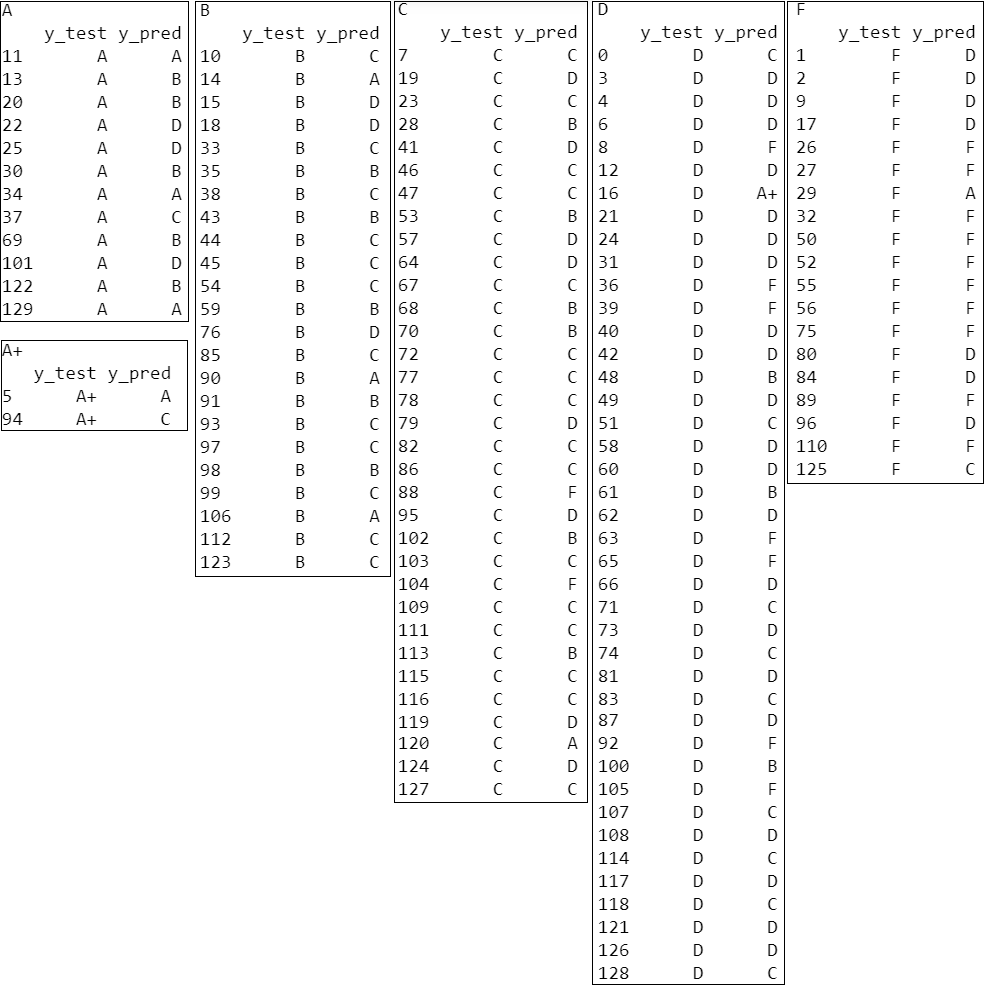

Furthermore, we use the describe() function to check what are the top predicted classes for each test class. We can see that for classes C/D/F, the top predicted classes are the same. Although the predictions for the classes A+/A/B are less accurate, their top predicted classes are A/B/C respectively, meaning that our model and features can at least predict close to the correct values for those classes, and there’s space for improvement in terms of training data. 

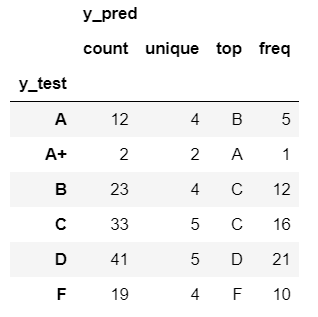

Intuitively, we can say that there might be a positive correlation between the amount of data provided for training the model and the accuracy level per class, meaning that the less data we provide to the model to be trained, the less accurate the model behaves. Furthermore, we construct a pivot table to show the y_test counts related to the y_pred counts and we add a column with the error rate per class. We can see that the higher error rate values correspond to A+/A/B. Moreover, we can say that there might be some bias towards classes B, given its high error rate and amount of predictions (similar to class F, which has a lower error rate), thus the errors might not be completely random.

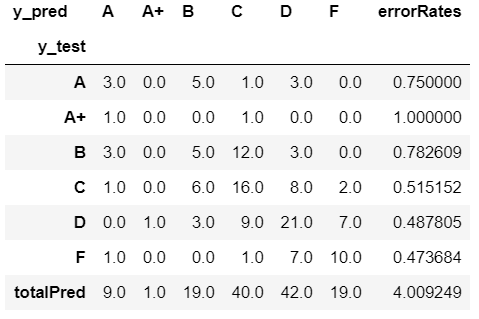

In [425]:
# Question 1 - Part 1, selecting test size, 

# Expected Wall time: 2 min 10 sec

import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn import metrics
import math

# Load data
data = load_data()
dataCopy = deepcopy(data)
results = 50
question = 1
splitFactors = [.75, .8, .9]
resultsDf = pd.DataFrame(0.0, index = range(results + 1), columns = ['train_.75', 'train_.8', 'train_.9'])

for i in range(len(splitFactors)):
    for j in resultsDf.index:
            resultsDf.loc[j][i] = runModelA(dataCopy, splitFactors[i], question)

resultsDf.loc['mean'] = resultsDf.mean()
resultsDf.loc['std'] = resultsDf.std()
resultsDf.loc['var'] = resultsDf.var()
resultsDf.tail(3)

,train_.75,train_.8,train_.9
mean,0.347616,0.347511,0.347210
std,0.032766,0.037890,0.043005
var,0.002923,0.003217,0.003560


In [342]:
# Question 1 - running the model

import pandas as pd
import math
from copy import deepcopy
from sklearn import metrics

# Load data
data = load_data()
dataCopy = deepcopy(data)
splitFactor = 0.8
question = 1

# Split data
X_train, X_test, y_train, y_test = split_data(dataCopy, splitFactor)

# Lists for traveling through dictionaries
Xfeat = list(X_train.columns) # Features list
yClass = list(y_train.value_counts().index) # Class count list
yClass.sort()

# Train
probDic, y_prior = train(X_train, y_train, yClass, Xfeat)

# Predict
y_pred = predict(y_prior, X_test, probDic, yClass, Xfeat)

# Evaluation
print(evaluate(y_test, y_pred, question))

0.4230769230769231


In [343]:
# Question 1 - inspecting the results

question = 1

# Evaluation
print(evaluate(y_test, y_pred, question))

# Addingg columns for manual inspections
X_testInspect = deepcopy(X_test)
X_testInspect['y_test'] = y_test
X_testInspect['y_pred'] = y_pred
X_testInspect

0.4230769230769231


,school,sex,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,y_test,y_pred
0,GP,F,R,LE3,T,mid,mid,services,services,course,...,no,3,3,2,2,2,3,none,D,C
1,MS,F,U,GT3,A,mid,high,other,services,reputation,...,no,2,3,2,1,3,1,more_than_ten,F,D
2,MS,F,R,GT3,T,low,low,at_home,other,course,...,yes,4,3,3,1,1,3,four_to_six,F,D
3,GP,M,U,GT3,T,mid,mid,services,other,home,...,no,4,4,4,2,4,5,more_than_ten,D,D
4,GP,M,U,LE3,A,high,low,services,other,home,...,yes,4,5,4,2,4,5,more_than_ten,D,D
5,GP,F,U,GT3,T,high,mid,health,services,reputation,...,no,4,2,2,1,2,3,none,A+,A
6,MS,F,R,GT3,A,mid,mid,health,other,course,...,yes,3,3,2,1,1,3,one_to_three,D,D
7,GP,M,U,GT3,T,mid,mid,other,other,home,...,no,5,3,3,1,1,3,none,C,C
8,MS,F,R,GT3,T,low,low,at_home,services,other,...,yes,4,1,3,1,1,2,four_to_six,D,F
9,GP,M,U,GT3,T,mid,mid,other,services,course,...,yes,4,5,5,4,4,5,none,F,D


In [432]:
# Question 1 - grouping the results

predictions = X_testInspect[['y_test', 'y_pred']].copy()
df = predictions.groupby('y_test')
for i, j in df:
    print(i)
    print(j)

A
    y_test y_pred
11       A      A
13       A      B
20       A      B
22       A      D
25       A      D
30       A      B
34       A      A
37       A      C
69       A      B
101      A      D
122      A      B
129      A      A
A+
   y_test y_pred
5      A+      A
94     A+      C
B
    y_test y_pred
10       B      C
14       B      A
15       B      D
18       B      D
33       B      C
35       B      B
38       B      C
43       B      B
44       B      C
45       B      C
54       B      C
59       B      B
76       B      D
85       B      C
90       B      A
91       B      B
93       B      C
97       B      C
98       B      B
99       B      C
106      B      A
112      B      C
123      B      C
C
    y_test y_pred
7        C      C
19       C      D
23       C      C
28       C      B
41       C      D
46       C      C
47       C      C
53       C      B
57       C      D
64       C      D
67       C      C
68       C      B
70       C      B
72       C      C
77  

In [345]:
# Question 1 - summary of results

df.describe()

y_pred                
        count unique top freq
y_test                       
A          12      4   B    5
A+          2      2   A    1
B          23      4   C   12
C          33      5   C   16
D          41      5   D   21
F          19      4   F   10

In [353]:
# Question 1 - confusion matrix

X_testInspect['y_pred_test'] = X_testInspect.apply(lambda x: 1, axis=1)
pivotTable = X_testInspect.pivot_table(index='y_test', columns='y_pred', values='y_pred_test', aggfunc=sum).fillna(0)
cm = pivotTable.copy()
pivotTable

y_pred,A,A+,B,C,D,F
y_test,,,,,,
A,3.0,0.0,5.0,1.0,3.0,0.0
A+,1.0,0.0,0.0,1.0,0.0,0.0
B,3.0,0.0,5.0,12.0,3.0,0.0
C,1.0,0.0,6.0,16.0,8.0,2.0
D,0.0,1.0,3.0,9.0,21.0,7.0
F,1.0,0.0,0.0,1.0,7.0,10.0


In [354]:
# Question 1 - error rates per class and total predictions per class

errorRates = []
aux = 0
for i in pivotTable.index:
    aux1 = 0
    for j in pivotTable.columns:
        aux = aux + pivotTable.loc[i][j]
        if i == j:
            aux1 = pivotTable.loc[i][j]
    aux = 1 - aux1/aux
    errorRates.append(aux)
    aux = 0
errorRates
pivotTable['errorRates'] = errorRates
pivotTable.loc['totalPred'] = pivotTable.sum()
pivotTable

y_pred,A,A+,B,C,D,F,errorRates
y_test,,,,,,,
A,3.0,0.0,5.0,1.0,3.0,0.0,0.750000
A+,1.0,0.0,0.0,1.0,0.0,0.0,1.000000
B,3.0,0.0,5.0,12.0,3.0,0.0,0.782609
C,1.0,0.0,6.0,16.0,8.0,2.0,0.515152
D,0.0,1.0,3.0,9.0,21.0,7.0,0.487805
F,1.0,0.0,0.0,1.0,7.0,10.0,0.473684
totalPred,9.0,1.0,19.0,40.0,42.0,19.0,4.009249


Question 2

a.	Fraud detection is useful context for (i) and (ii). We have two labels to identify among a large dataset (“not-fraud”, “fraud”), with “not-fraud” representing the very greater part of the cases. Accuracy will represent (# correct predictions)/(total # of predictions), our objective is to find the TPs, so, a 99% of accuracy could be misleading, thus the accuracy works better with balanced classes. Recall will focus on finding all the interesting cases in the dataset (re=(TP/(TP+FN)), so, the less FNs  the higher recall. The recall score has a trade-off with the precision score, which represents the fraction of cases that the model said to be interesting and actually were interesting (pr=(TP/(TP+FP)). We might prefer to have a higher recall, accepting a low precision if the follow-up procedure of fraud is not costly. The f1 score is the harmonic mean of precision and recall, so, it would be useful if we want a balance between both (low FP and low FN). 
(iii) For a multiclass problem, precision, recall and f1 score can be calculated per class and then averaged. The difference between macro and micro averaging is that the macro calculates each measure independently for each class and micro aggregates the contributions of every class to calculate average. In our case the dataset is not balanced across all the classes. The macro average value could be a good performance measure given that it will treat all classes equally, as we are not interested in a particular class, we aim to have a better overall result.

b.	The values for accuracy, precision, recall and f1 score (including macro-averaging) were calculated with the same y_test and y_pred values from Q1.c for the sake of the analysis, by using the classification report from sklearn and the confusion matrix.

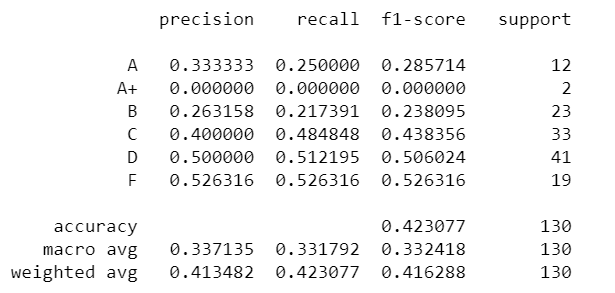 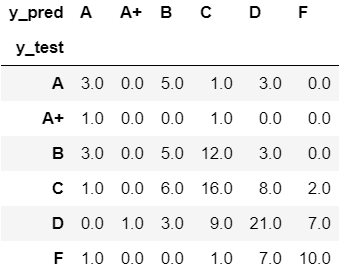

Following the argument from Q1.c, we can see that the values of precision/recall/f1 for classes A+/A/B are lower compared to the ones from C/D/F, due to the differences in the amount of data for training. If we compare the accuracy against the precision/recall/f1 values per class, we can see that those tend to be higher for C/D/F, meaning that those classes have more TP values and less FP/FN values compared to A+/A/B classes. This means that there is space for improvement for the A+/A/B in terms of the amount of training data. In the case of the macro average values of precision/recall/f1, we can see that those values are lower compared to the overall accuracy, which means that the contribution of each class has been treated equally irrespective of their size, which is convenient in our dataset context, where we have an imbalanced dataset and each class/grade gives equally important information. Regarding additional knowledge, we can notice that accuracy might not always be the only important measure in machine learning. We first set a context for our problem in terms of the meaning of the performance measures, then look at precision/recall/f1 and manage the trade-off between the measures. If there’s space for improvement (to increase the TP values), we can decide whether to get more data or perform other training strategies.


In [349]:
# Question 2 - classification report

question = 2
print(evaluate(y_test, y_pred, question))

              precision    recall  f1-score   support

           A   0.333333  0.250000  0.285714        12
          A+   0.000000  0.000000  0.000000         2
           B   0.263158  0.217391  0.238095        23
           C   0.400000  0.484848  0.438356        33
           D   0.500000  0.512195  0.506024        41
           F   0.526316  0.526316  0.526316        19

    accuracy                       0.423077       130
   macro avg   0.337135  0.331792  0.332418       130
weighted avg   0.413482  0.423077  0.416288       130



In [355]:
# Question 2 - confusion matrix
cm

y_pred,A,A+,B,C,D,F
y_test,,,,,,
A,3.0,0.0,5.0,1.0,3.0,0.0
A+,1.0,0.0,0.0,1.0,0.0,0.0
B,3.0,0.0,5.0,12.0,3.0,0.0
C,1.0,0.0,6.0,16.0,8.0,2.0
D,0.0,1.0,3.0,9.0,21.0,7.0
F,1.0,0.0,0.0,1.0,7.0,10.0


Question 3

a.	We select the strategy called Cross-Validation to be compared with the hold-out strategy. Instead of hold-out strategy, where the data is partitioned one time in two subsets randomly, namely training and testing subsets, Cross-Validation progressively splits the data in a number partitions (m>=2), where we iteratively use one partition as testing and the other m – 1 partitions as training data, and the evaluation metric is aggregated using the average across all iterations. This strategy might be better compared to hold-out strategy because every instance becomes a test instance for some partition, thus our overall test set will be highly representative of the overall dataset, and the accuracy will be calculated w.r.t. the whole dataset. Instead, hold-out strategy has the disadvantage that the size of the partition will affect the estimate of the model’s behavior, having to deal with the trade-off between building a more accurate model versus having a representative test data. Moreover, the Cross-Validation strategy tends to minimize both testing bias, by ensuring that the training phase will be the as close as possible to using the whole dataset for training, and testing variance, by ensuring that we use a sufficient amount of data for testing. Finally, the amount of partitions to use will also introduce us to a trade-off between bias and variance, meaning that less partitions could lead us to higher bias in the estimates and less variance. In the other hand, a higher number of partitions could lead us to lower bias in the estimates but a higher variance.

b.	We implemented Cross Validation (CV) with 5, 10 and 649 folds (Leave-One-Out-CV) for the results to be compared with the result of Q1.c. Our three results are similar in terms of mean, but as the amount of folds goes higher, so does the variance and standard deviation as well. 

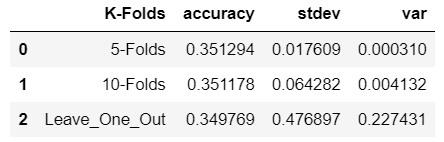

Moreover, if we look at the range of values of the accuracy lists of 5-Folds, 10-Folds and LOOCV, it becomes wider every time we increase the folds, leading to higher variance. 

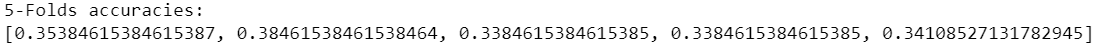
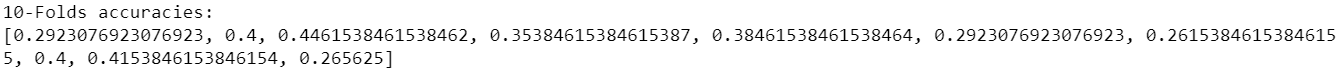
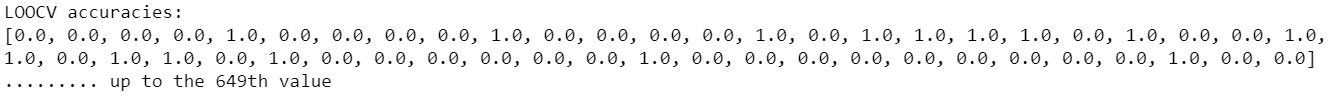

For this results to be compared to the Q1.c value, we will focus on the 5-Folds CV, given that it mimics our 80/20 hold out strategy from above. In this case, we can see that the accuracy value obtained for 5-Folds is lower, but more reliable, given that we use the average of five iterations of CV, whereas the accuracy value of the hold-out strategy highly depends on random selection of the test and training instances. Furthermore, our 5-Folds CV strategy shows a more reliable result in terms of overall accuracy by using a test set that is more representative of the overall dataset. In addition, the CV technique gives us a standardized answer to compare different models, meaning that the selection of a particular amount of folds will allow us to compare different approaches (models) to solve the same problem. Thus, hold-out strategy would not be a reliable way for comparing accuracy scores of different models.


In [423]:
# Question 3 - KFold Cross Validation

# Expected Wall time: 6 min

import pandas as pd
import numpy as np
import math
from copy import deepcopy
from sklearn import metrics
from statistics import mean

# Load data
data = load_data()
dataCopy = deepcopy(data)
featNames = dataCopy.drop(columns = ['Grade'])
featNames = featNames.columns
question = 3

folds = [5, 10, 649]
lines = dataCopy.shape[0]
meanAccuracy = []
allAcc = [[],[],[]]
X = dataCopy.iloc[ :, :-1]
y = dataCopy.iloc[ :, -1]

for fold in range(len(folds)):
    foldLength = round(lines / folds[fold])
    accuracies = []
    for line in range(0, lines, foldLength):
        lastLine = line + foldLength if line + foldLength <= lines else lines
        pos = range(line, lastLine)
        split = np.ones(lines, dtype = bool)
        split[pos] = False
        X_train = X[split]
        X_train = pd.DataFrame(data = X_train, columns = featNames)
        X_train.reset_index(drop = True, inplace = True)
        y_train = y[split]
        y_train = pd.DataFrame(data = y_train, columns = ['Grade'])
        y_train=y_train.iloc[ :, 0]
        y_train.reset_index(drop = True, inplace = True)
        X_test = X[~split]
        X_test = pd.DataFrame(data = X_test, columns = featNames)
        X_test.reset_index(drop = True, inplace = True)
        y_test = y[~split]
        y_test = pd.DataFrame(data = y_test, columns = ['Grade'])
        y_test = y_test.iloc[ :, 0]
        y_test.reset_index(drop = True, inplace = True)
        accuracy = runModelC(X_train, y_train, X_test, y_test, question)
        accuracies.append(accuracy)
    meanAccuracy.append(mean(accuracies))
    allAcc[fold].append(accuracies)

KFoldDict = {'K-Folds':['5-Folds', '10-Folds', 'Leave_One_Out'], 'accuracy':[meanAccuracy[0], meanAccuracy[1], meanAccuracy[2]]
            , 'stdev':[np.std(allAcc[0][0]), np.std(allAcc[1][0]), np.std(allAcc[2][0])]
            , 'var':[np.var(allAcc[0][0]), np.var(allAcc[1][0]), np.var(allAcc[2][0])]} 
KFoldValues = pd.DataFrame(KFoldDict) 
KFoldValues

,K-Folds,accuracy,stdev,var
0,5-Folds,0.351294,0.017609,0.000310
1,10-Folds,0.351178,0.064282,0.004132
2,Leave_One_Out,0.349769,0.476897,0.227431


In [451]:
# Accuracies 5-Folds
print("5-Folds stdev: ", np.std(allAcc[0][0]))
print("5-Folds variance: ", np.var(allAcc[0][0]))
print("5-Folds accuracies: ")
print(allAcc[0][0])

5-Folds stdev:  0.017609034280826545
5-Folds variance:  0.0003100780883033245
5-Folds accuracies: 
[0.35384615384615387, 0.38461538461538464, 0.3384615384615385, 0.3384615384615385, 0.34108527131782945]


In [450]:
# Accurcies 10-Folds
print("10-Folds stdev: ", np.std(allAcc[1][0]))
print("10-Folds variance: ", np.var(allAcc[1][0]))
print("10-Folds accuracies: ")
print(allAcc[1][0])

10-Folds stdev:  0.06428160143827265
10-Folds variance:  0.004132124283468936
10-Folds accuracies: 
[0.2923076923076923, 0.4, 0.4461538461538462, 0.35384615384615387, 0.38461538461538464, 0.2923076923076923, 0.26153846153846155, 0.4, 0.4153846153846154, 0.265625]


In [454]:
# Accuracies LOOCV
print("LOOCV stdev: ", np.std(allAcc[2][0]))
print("LOOCV variance: ", np.var(allAcc[2][0]))
print("LOOCV accuracies: ")
print(allAcc[2][0][:50], "......... up to the 649th value")

LOOCV stdev:  0.47689685377354357
LOOCV variance:  0.22743060913910462
LOOCV accuracies: 
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0] ......... up to the 649th value
